In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [21]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3
EPOCHS=15

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
     "Plant_image",
     shuffle=True,
     image_size=(IMAGE_SIZE,IMAGE_SIZE),
     batch_size=BATCH_SIZE
 )

Found 1404 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Anthracnose', 'Cercospora', 'Healthy']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)
    print(label_batch.numpy())

(256, 256, 3)
[1 0 0 2 2 0 2 1 2 2 1 1 1 1 2 2 0 0 2 0 2 2 2 2 1 2 0 2 2 2 1 1]


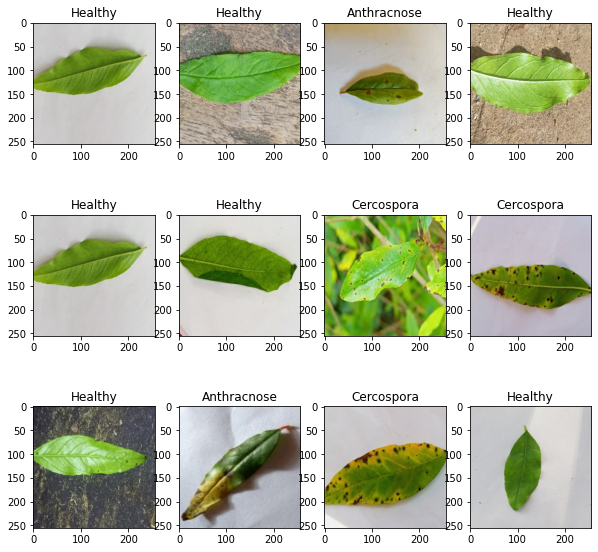

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("on")

In [7]:
len(dataset)

44

# 80% for training, 10% for validation, 10% for test

In [8]:
def get_data_pratition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=10)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds=get_data_pratition_tf(dataset)

In [10]:
len(train_ds)

35

In [11]:
len(val_ds)

4

In [12]:
len(test_ds)

5

In [13]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
]

)

In [15]:
data_augmentaion=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
]
)

In [16]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentaion,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax"),
    
    
]
)
model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [18]:
model.compile(
optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [22]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/15
35/35 [==============================] - 146s 4s/step - loss: 0.2580 - accuracy: 0.9080 - val_loss: 0.3234 - val_accuracy: 0.9062
Epoch 2/15
35/35 [==============================] - 146s 4s/step - loss: 0.2156 - accuracy: 0.9125 - val_loss: 0.1824 - val_accuracy: 0.9297
Epoch 3/15
35/35 [==============================] - 146s 4s/step - loss: 0.1830 - accuracy: 0.9312 - val_loss: 0.2188 - val_accuracy: 0.8984
Epoch 4/15
35/35 [==============================] - 146s 4s/step - loss: 0.1607 - accuracy: 0.9330 - val_loss: 0.1537 - val_accuracy: 0.9375
Epoch 5/15
35/35 [==============================] - 145s 4s/step - loss: 0.1425 - accuracy: 0.9384 - val_loss: 0.1504 - val_accuracy: 0.9375
Epoch 6/15
35/35 [==============================] - 147s 4s/step - loss: 0.1114 - accuracy: 0.9589 - val_loss: 0.1650 - val_accuracy: 0.9297
Epoch 7/15
35/35 [==============================] - 148s 4s/step - loss: 0.0961 - accuracy: 0.9634 - val_loss: 0.1184 - val_accuracy: 0.9531
Epoch 8/15
35

In [23]:
scores=model.evaluate(test_ds)

5/5 [==============================] - 10s 1s/step - loss: 0.0637 - accuracy: 0.9750


In [24]:
scores

[0.06369686871767044, 0.9750000238418579]

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
acc=history.history['accuracy']
val_acc=history.history["val_accuracy"]
loss=history.history['loss']
val_loss=history.history["val_loss"]

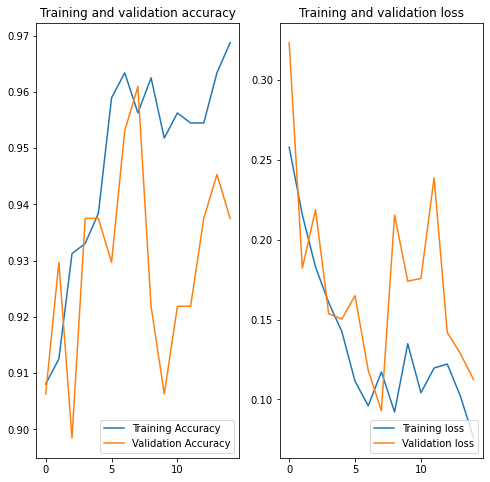

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and validation accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training loss")
plt.plot(range(EPOCHS),val_loss,label="Validation loss")
plt.legend(loc="lower right")
plt.title("Training and validation loss")
plt.show()

First image to predict
First image actual label :  Healthy
1/1 [==============================] - 2s 2s/step
Predeicted label : Healthy


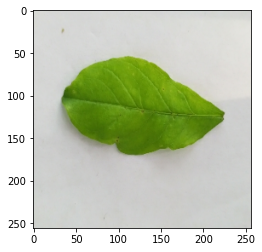

In [28]:
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label : ",class_names[first_label])
    
    batch_prediction=model.predict(image_batch)
    print("Predeicted label :",class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidance=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidance

1/1 [==============================] - 0s 62ms/step


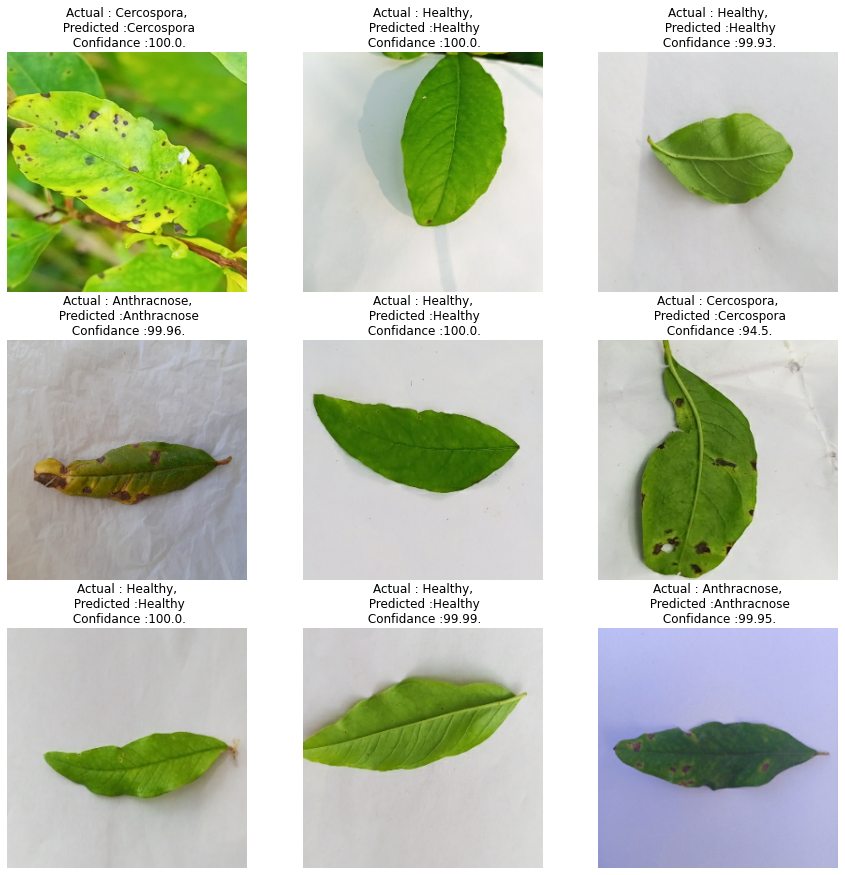

In [30]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidance=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual : {actual_class},\n Predicted :{predicted_class}\n Confidance :{confidance}.")
        plt.axis("off")